In [1]:
!pip install matplotlib-venn

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

4423680/4422102 [==============================] - 0s 0us/step


Question 1: Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

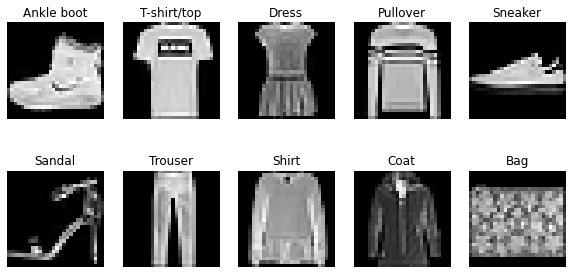

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[Y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[Y_train[i]]) 
      plt.imshow(X_train[i],cmap='gray')
      plt.axis("off")
      plottedClass[Y_train[i]]=True
      count=count+1

plt.show()

**Backpropagation code stage1.**

In [5]:
import numpy as np

In [6]:
from sklearn.preprocessing import OneHotEncoder

print("Train data shape {} : Train label shape {}".format(X_train.shape,Y_train.shape))
print("Test data shape {} : Test label shape {}".format(X_test.shape,Y_test.shape))

#flatten the Xtrain and X_test
X_tr=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_ts=X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#create one hot encoding of the labels
Y_tr=OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()
Y_ts=OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()

print("After reshaping...")

print("Train data shape {} : Train label shape {}".format(X_tr.shape,Y_tr.shape))
print("Test data shape {} : Test label shape {}".format(X_ts.shape,Y_ts.shape))

#normalizing the train data...
X_tr=X_tr/255
X_ts=X_ts/255

Train data shape (60000, 28, 28) : Train label shape (60000,)
Test data shape (10000, 28, 28) : Test label shape (10000,)
After reshaping...
Train data shape (60000, 784) : Train label shape (60000, 10)
Test data shape (10000, 784) : Test label shape (10000, 10)


In [82]:
class Activation:

  def Sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def Softmax(self,x):
    numr=np.exp(x)
    return numr/sum(np.exp(x))

  def Relu(self,x):
    return 1

  def Tanh(self,x):
    numr=np.exp(x)-np.exp(-x)
    denom=np.exp(x)+np.exp(-x)
    return numr/denom

  def Derivative_Sigmoid(self,x):
    s=1/(1+np.exp(-x))
    return s*(1-s)

  def Derivative_Relu(self,x):
    return 1  

  def Derivative_Tanh(self,x):
    return 1-self.Tanh(x)**2

  def Linear(self,x):
    return x


In [8]:
class Loss:

  #Takes ypred as [[],[]] and y as [[],[]]
  def CategoricalCrossEntropy(self,ypred,y):
    class_idx=np.argmax(y,axis=1)
    cce_loss=0
    for i in range(len(class_idx)):
      cce_loss+=(-1)*np.log2(ypred[i][class_idx[i]])
    return cce_loss/len(ypred)


  def meansquarederror(self,ypred,y):

    #check for correct squared loss function
    return np.sum((ypred-y)**2)



In [58]:
class Layer:

  def __init__(self,num_inputs,num_neurons,activation,optimizer):
    
    self.num_inputs=num_inputs
    self.num_neurons=num_neurons
    self.activation=activation
    self.optimizer=optimizer

    self.W=np.random.normal(loc=0.0,scale=2.0,size=(self.num_neurons,self.num_inputs))
    self.b=np.random.normal(loc=0.0,scale=2.0,size=(self.num_neurons,))

    self.del_h=np.zeros((self.num_neurons,))
    self.del_a=np.zeros((self.num_neurons,))
    self.delW=np.zeros((self.num_neurons,self.num_inputs))
    self.prev_Uw=np.zeros((self.num_neurons,self.num_inputs))
    self.delb=np.zeros((self.num_neurons,))
    self.prev_Ub=np.zeros((self.num_neurons,))

    self.aL=np.zeros((self.num_neurons,))
    self.hL=np.zeros((self.num_neurons,))
  

  def show_details(self):
    #print("Hidden Layer..")
    
    print("number of neurons :",self.num_neurons)
    print("number of inputs :",self.num_inputs)
    print("shape of weights :",self.W.shape)
    print("shape of biases :",self.b.shape)
    print("shape of hL :",self.hL.shape)
    print("shape of aL :",self.aL.shape)


  def Forward(self,h_L_1):
    
    self.aL=np.dot(self.W,h_L_1)+self.b
    ac=Activation()
    
    if self.activation=="Relu":
      self.hL=ac.Relu(self.aL)

    elif self.activation=="Tanh":
      self.hL=ac.Tanh(self.aL)
    
    elif self.activation=="Softmax":
      self.hL=ac.Softmax(self.aL)
    
    elif self.activation=="linear":
      self.hL=ac.Linear(self.aL)

    else:
      self.hL=ac.Sigmoid(self.aL)

    


  def get_gradients(self,isoplayer,Y_hat,Y,prev_hL,nextW,next_aL):
      
      #If it is the output layer...
      if isoplayer==1:

        if self.activation=="Softmax":
          for i in range(len(Y_hat)):
            self.del_h+=(-1/Y_hat[i][np.argmax(Y[i])]*Y[i])

          for i in range(len(Y_hat)):  
            self.del_a+=(Y_hat[i]-Y[i])
      
      #write the gradients formula for linear activation...
        else:
          pass

      #if it is not the output layer..
      else:
        self.del_h=np.dot((nextW).T,next_aL)

        #gradients wrt pre activation for different Activation function used..
        if self.activation=="Relu":
          self.del_a=(self.del_h)*(Activation().Derivative_Relu(self.aL))

        elif self.activation=="Tanh":
          self.del_a=(self.del_h)*(Activation().Derivative_Tanh(self.aL))
      
        else:
          self.del_a=(self.del_h)*(Activation().Derivative_Sigmoid(self.aL))

      self.delW=np.dot(self.del_a.reshape(-1,1),prev_hL.reshape(1,-1))
      self.delb=self.del_a

  def update_parameters(self,eta,gamma):

    if self.optimizer=="Simple_GD":
      self.W=self.W-eta*self.delW
      self.b=self.b-eta*self.delb

    elif self.optimizer=="Moment_Based":

      Uw_t=gamma*self.prev_Uw+eta*self.delW
      Ub_t=gamma*self.prev_Ub+eta*self.delb

      self.W=self.W-Uw_t
      self.b=self.b-Ub_t

      self.prev_Uw=Uw_t
      self.prev_Ub=Ub_t


    elif self.optimizer=="Nestrov":
      pass

    else:
      pass

    
  def reset_gradients(self):
    
    self.del_h=np.zeros((self.num_neurons,))
    self.del_a=np.zeros((self.num_neurons,))
    self.delW=np.zeros((self.num_neurons,self.num_inputs))
    self.delb=np.zeros((self.num_neurons,))

  

In [10]:
class IpLayer:

  def __init__(self,num_neurons):
    self.num_neurons=num_neurons
    self.hL=np.zeros((self.num_neurons,))

  def show_details(self):
    print("Input Layer")
    print("for input layer the hL :",self.hL.shape)


  def Forward(self,x):
    self.hL=x


In [59]:
class NN:

  def __init__(self,input_shape,num_hlayers,neurons,activations,optimizer,output_shape):

    self.input_shape=input_shape
    self.output_shape=output_shape
    self.num_hlayers=num_hlayers
    self.neurons=neurons
    self.HLAc=activations[0]
    self.OPAc=activations[1]
    self.optimizer=optimizer

    self.Layers=[]
    self.eta=1e-3
    self.gamma=0.1
    self.loss=0.0

    #used to store the predicted probabilities of passed data
    self.Y_hat=[]

  
  def create_architecture(self):

    #create input layer
    self.Layers.append(IpLayer(self.input_shape))

    #hidden layers..
    for layer in range(1,self.num_hlayers+2):
      
      ip_shape=self.Layers[layer-1].num_neurons

      #output layer...
      if layer==self.num_hlayers+1:
         self.Layers.append(Layer(ip_shape,self.output_shape,self.OPAc,self.optimizer))
      
      else:
        self.Layers.append(Layer(ip_shape,self.neurons[layer-1],self.HLAc,self.optimizer))


  def Structural_Desc(self):
    
    for i in range(0,self.num_hlayers+2):
      print("Layer Number : ",i)
      self.Layers[i].show_details()
      print("--"*50)


  def Feed_Forward(self,X_train,Y_train):
    self.loss=0
    self.Y_hat=[]
    
    for i in range(X_train.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X_train[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      self.Y_hat.append(ypred)
      
    self.loss=Loss().CategoricalCrossEntropy(self.Y_hat,Y_train)
     

  def Back_Propogation(self,Y):
    
    #getting gradients for hidden layers..
    for i in range(self.num_hlayers+1,0,-1):
      prev_hL=self.Layers[i-1].hL
      if i==self.num_hlayers+1:
        self.Layers[i].get_gradients(1,self.Y_hat,Y,prev_hL,0,0)
      else:
        next_W=self.Layers[i+1].W
        next_aL=self.Layers[i+1].aL
        self.Layers[i].get_gradients(0,self.Y_hat,Y,prev_hL,next_W,next_aL)

      
  #update W,b for each layer...
  def update_parameters(self):
    
    for i in range(1,self.num_hlayers+2):
      self.Layers[i].update_parameters(self.eta,self.gamma)

  #reset gradients for each layer...
  def reset_gradients(self):

    for i in range(1,self.num_hlayers+2):
      self.Layers[i].reset_gradients()
    
    self.loss=0


**Training..**

In [60]:
#considering this subset of data as train data..
X_sample=X_tr[:2000]
Y_sample=Y_tr[:2000]

In [42]:
class GD_Versions:

  #NN is after creating architecture...
  def __init__(self,NN,X_train,Y_train,epochs):

    self.NN=NN
    self.X=X_train
    self.Y=Y_train
    self.epochs=epochs

  def Batch_GD(self):

    Lossr=[]
    for i in range(self.epochs):
      self.NN.Feed_Forward(self.X,self.Y)
      Lossr.append(self.NN.loss)
  
      self.NN.Back_Propogation(self.Y)
      self.NN.update_parameters()
      self.NN.reset_gradients()

    self.NN.Feed_Forward(self.X,self.Y)
    loss_final=self.NN.loss/len(self.Y)
    cp=np.sum(np.argmax(np.array(self.NN.Y_hat),axis=1)==np.argmax(self.Y,axis=1))/len(self.Y)

    return (Lossr,cp,loss_final)
  
  def SGD(self):

    Lossr=[]
    for i in range(self.epochs):

      n=self.X.shape[0]

      for dpi in range(n):

        self.NN.Feed_Forward(self.X[dpi].reshape(1,-1),self.Y[dpi].reshape(1,-1))

        self.NN.Back_Propogation(self.Y[dpi])
        self.NN.update_parameters()
        self.NN.reset_gradients()

      #calculate the loss after 1 epoch...
      self.NN.Feed_Forward(self.X,self.Y)
      Lossr.append(self.NN.loss)

    self.NN.Feed_Forward(self.X,self.Y)
    loss_final=self.NN.loss/len(self.Y)
    cp=np.sum(np.argmax(np.array(self.NN.Y_hat),axis=1)==np.argmax(self.Y,axis=1))/len(self.Y)

    return (Lossr,cp,loss_final)

  def Mini_Batch(self,batch_size):
    Lossr=[]

    n=self.X.shape[0]

    #batch gradient descent..
    for i in range(self.epochs):

      sidx=0
      while sidx+batch_size <= n:
        self.NN.Feed_Forward(self.X[sidx:sidx+batch_size],self.Y[sidx:sidx+batch_size])
        self.NN.Back_Propogation(self.Y[sidx:sidx+batch_size])
        self.NN.update_parameters()
        self.NN.reset_gradients()

        sidx+=batch_size
    
      if sidx!=n:
        self.NN.Feed_Forward(self.X[sidx:n],self.Y[sidx:n])
        self.NN.Back_Propogation(self.Y[sidx:n])
        self.NN.update_parameters()
        self.NN.reset_gradients()
    
      self.NN.Feed_Forward(self.X,self.Y)
      Lossr.append(self.NN.loss)

    self.NN.Feed_Forward(self.X,self.Y)
    loss_final=self.NN.loss/len(self.Y)
    cp=np.sum(np.argmax(np.array(self.NN.Y_hat),axis=1)==np.argmax(self.Y,axis=1))/len(self.Y)

    return (Lossr,cp,loss_final)


In [83]:
arch1=NN(input_shape=784,num_hlayers=1,neurons=[64],activations=['Tanh','Softmax'],optimizer='Moment_Based',output_shape=10)
arch1.create_architecture()

epochs=1000
gd_v=GD_Versions(arch1,X_sample,Y_sample,epochs)
#Loss_batch,accuracy_batch,lf_batch=gd_v.Batch_GD()

Loss_mbatch,accuracy_mbatch,lf_mbatch=gd_v.Mini_Batch(32)

#Loss_sgd,accuracy_sgd,lf_sgd=gd_v.SGD()



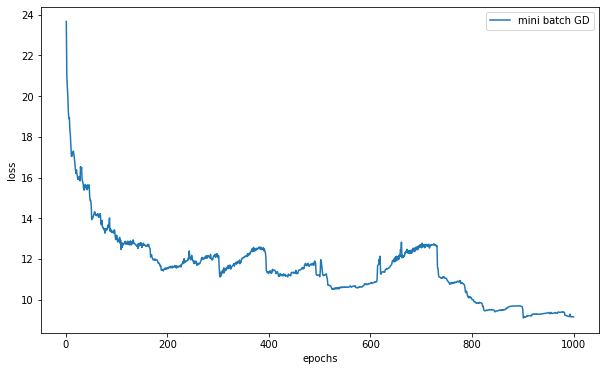

Accuracy with miniBatch :  0.106


In [84]:
plt.figure(figsize=(10,6))
#plt.plot(np.arange(1,epochs+1),Loss_batch,label="Batch GD")
plt.plot(np.arange(1,epochs+1),Loss_mbatch,label="mini batch GD")
#plt.plot(np.arange(1,epochs+1),Loss_sgd,label="SGD")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#print("Accuracy with BatchGD : ",accuracy_batch)
print("Accuracy with miniBatch : ",accuracy_mbatch)
#print("Accuracy with SGD : ",accuracy_sgd)


In [85]:
def plot_confusion_mtx(matrix,num_classes):

  plt.figure(figsize=(10,8))
  ax= plt.subplot()
  cmap=sns.light_palette("orange")
  sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f"); 
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels([str(i) for i in range(num_classes)]); ax.yaxis.set_ticklabels([str(i) for i in range(num_classes)]);
  plt.show()

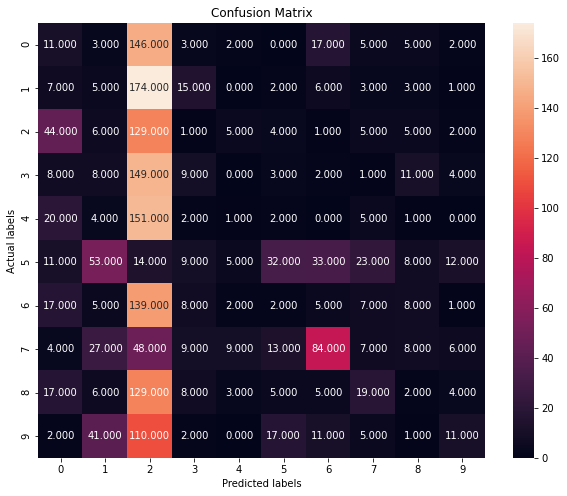

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf=confusion_matrix(y_true=np.argmax(Y_sample,axis=1),y_pred=np.argmax(arch1.Y_hat,axis=1))
plot_confusion_mtx(cf,10)